Prepares the dataset for classification by:
- Accessing Parquet data from an AWS S3 bucket
- Formatting and standardizing training data
- Assessing different approaches to address class imbalance (e.g. synthetic data generation, augmentation)
- Preprocessing test data for evaluation and cross-validation

In [0]:
# "standard"
import numpy as np
import pandas as pd

# plotting
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold

# misc
from IPython.display import clear_output
from imblearn.over_sampling import SMOTE
from collections import Counter

# Preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# src
import sys
sys.path.append('/Workspace/Users/bjedelma@gmail.com/Alzheimers-MRI-Classification/src')
from img_preprocessing import dict_to_image
from data_io import save_pickle_s3

clear_output(wait=False)


Mount AWS S3 bucket containing raw data parquet files

In [0]:
ACCESS_KEY = dbutils.secrets.get(scope="brad-aws", key="access_key")
SECRET_KEY= dbutils.secrets.get(scope="brad-aws", key="secret_key")

# specify bucket and mount point
AWS_S3_BUCKET = "databricks-workspace-stack-brad-personal-bucket/AD_MRI_classification/raw/"
MOUNT_NAME = f"/mnt/{AWS_S3_BUCKET.split('/')[-2]}"
SOURCE_URL = f"s3a://{AWS_S3_BUCKET}"
EXTRA_CONFIGS = { "fs.s3a.access.key": ACCESS_KEY, "fs.s3a.secret.key": SECRET_KEY}

# mount bucket
if any(mount.mountPoint == MOUNT_NAME for mount in dbutils.fs.mounts()):
    print(f"{MOUNT_NAME} is already mounted.")
else:
    dbutils.fs.mount(SOURCE_URL, MOUNT_NAME, extra_configs = EXTRA_CONFIGS)
    print(f"{MOUNT_NAME} is now mounted.")

/mnt/raw is already mounted.


Load and format training data

In [0]:
'''
Label meanings
0 - Mild dementia
1 - Moderate dementia
2 - No dementia
3 - Very mild dementia
'''
Lab = ['Mild', 'Moderate', 'None', 'Very Mild']

train = pd.read_parquet("/dbfs/mnt/AD_classification/raw/train-00000-of-00001-c08a401c53fe5312.parquet")
train.head()

,image,label
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2


Convert data to readable format

In [0]:
train['img_arr'] = train['image'].apply(dict_to_image)
train.drop("image", axis=1, inplace=True)
train.head()

,label,img_arr
0,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


Load and convert test data

In [0]:
test = pd.read_parquet("/dbfs/mnt/AD_classification/raw/test-00000-of-00001-44110b9df98c5585.parquet")
test.head() 

# Also convert to readable format
test['img_arr'] = test['image'].apply(dict_to_image)
test.drop("image", axis=1, inplace=True)
test.head()

,label,img_arr
0,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


Examine some sample images to check data quality

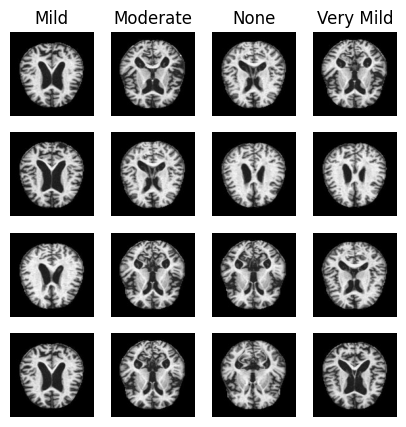

In [0]:
train_lab_idx = np.asarray(train.iloc[:].label)

f, ax = plt.subplots(4, 4, figsize=(5, 5))
for lab in range(4):
    for ex in range(4):
    
        class_lab = np.argwhere(train_lab_idx == 1)
        current_idx = np.random.randint(len(class_lab)-1,size = 1)
        current_idx = np.asarray(current_idx)
        
        ax[ex, lab].axis('off')
        ax[ex, lab].imshow(train.iloc[class_lab[current_idx[0]][0]].img_arr, cmap = "gray")
        if ex == 0: ax[ex, lab].set_title(Lab[lab])

Clearly, images show different slices within the brain, which may be a major confound...

Explore distribution of dataset classes

Text(0, 0.5, '# of images')

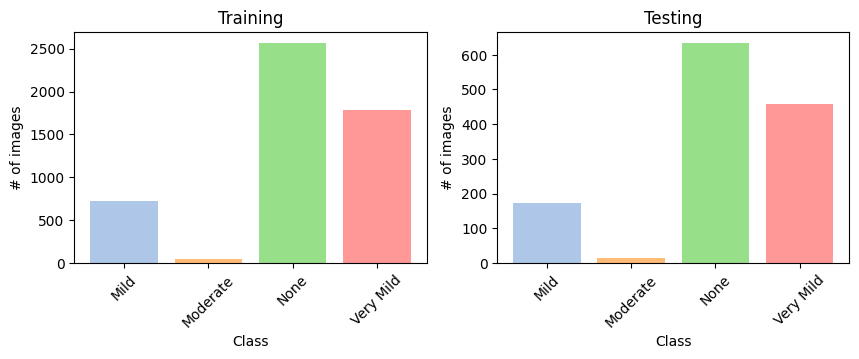

In [0]:
colors = ['#aec7e8', '#ffbb78', '#98df8a', '#ff9896']

f, ax = plt.subplots(1, 2, figsize=(10, 3))
unique, counts = np.unique(np.asarray(train.iloc[:].label), return_counts=True)
ax[0].bar(unique, counts, color=colors)
ax[0].set_xticks(unique)
ax[0].set_xticklabels(Lab, rotation=45)
ax[0].set_title('Training')
ax[0].set_xlabel('Class')
ax[0].set_ylabel('# of images')

unique, counts = np.unique(np.asarray(test.iloc[:].label), return_counts=True)
ax[1].bar(unique, counts, color=colors)
ax[1].set_xticks(unique)
ax[1].set_xticklabels(Lab, rotation=45)
ax[1].set_title('Testing')
ax[1].set_xlabel('Class')
ax[1].set_ylabel('# of images')

We can see that there is an obvious imbalance across classes in both the training and testing sets. However, each class has been proportionally split between the two. Nevertheless, let's attempt to balance the training set such that the model sees equal numbers of each class. To avoid overfitting (e.g. simple resampling), we use the SMOTE method here to synthetically generate new data based on what is available.

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Text(0, 0.5, '# of images')

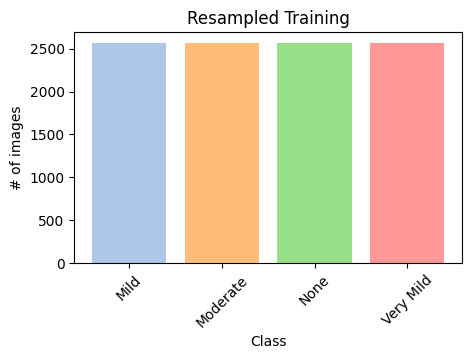

In [0]:
# Extract features and labels
train_tmp = np.array([img.flatten() for img in train['img_arr']])
train_lab_tmp = train['label']

# Apply SMOTE
smote = SMOTE(random_state=42)
train_smote, train_smote_lab = smote.fit_resample(train_tmp.reshape(-1, 128*128), train_lab_tmp)
train_smote = train_smote.reshape(-1, 128, 128)

# Create a new DataFrame with the resampled data
train_smote = pd.DataFrame({'label': train_smote_lab, 'img_arr': [img.tolist() for img in train_smote]})
train_smote_lab = train_smote['label']

# Plot the distribution of the different classes
colors = ['#aec7e8', '#ffbb78', '#98df8a', '#ff9896']

f, ax = plt.subplots(1, 1, figsize=(5, 3))
unique, counts = np.unique(train_smote_lab, return_counts=True)
ax.bar(unique, counts, color=colors)
ax.set_xticks(unique)
ax.set_xticklabels(Lab, rotation=45)
ax.set_title('Resampled Training')
ax.set_xlabel('Class')
ax.set_ylabel('# of images')

Now we see that the training set is balanced across classes. Let's inspect some of the new data for quality.

Class Mild: 5143 synthetic images
Class Moderate: 3302 synthetic images
Class Very Mild: 785 synthetic images


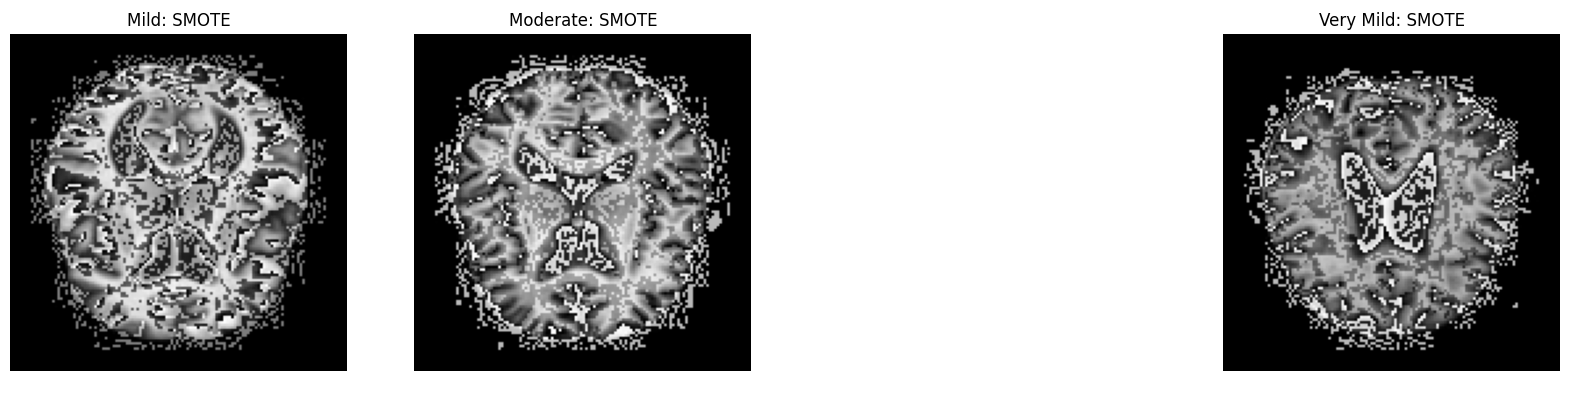

In [0]:
first_indices = {}
for num in range(0, 4):
    first_index = next((i for i, x in enumerate(train_smote_lab[5121:], start=5121) if x == num), None)
    first_indices[num] = first_index

for label, index in first_indices.items():
    if index is not None:
        num_synthetic_images = len(train_smote_lab) - index
        print(f"Class {Lab[label]}: {num_synthetic_images} synthetic images")

# Visualize the images from the first_indices values
f, ax = plt.subplots(1, 4, figsize=(20, 5))
for i, label in enumerate(np.unique(train_smote_lab)):
    if first_indices[label] is not None:
        first_image = np.array(train_smote.iloc[first_indices[label]]['img_arr']).reshape(128, 128)
        ax[i].imshow(first_image, cmap='gray')
        ax[i].set_title(f"{Lab[label]}: SMOTE")
    ax[i].axis('off')

In these cases, SMOTE did not successfully generate accurate synthetic data. While some realistic features are apparent, the overall quality is poor. Therefore, we will attemp to balance classes using a classic augmentation approach.

In [0]:
train_tmp = np.array([img for img in train['img_arr']])
train_tmp = train_tmp.reshape(-1, 128, 128, 1)

train_lab_tmp = train['label'].values

# Calculate class distribution
class_counts = Counter(train_lab_tmp)

# Split the data by class
class_images = {}  # Dictionary to hold images by class
class_labels = {}  # Dictionary to hold labels by class

for img, label in zip(train_tmp, train_lab_tmp):
    if label not in class_images:
        class_images[label] = []
        class_labels[label] = []
    class_images[label].append(img)
    class_labels[label].append(label)

# Plot one image from class_images
label_to_plot = list(class_images.keys())[0]  # Select the first label
image_to_plot = class_images[label_to_plot][0]  # Select the first image of that label

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Augment the minority classes
max_samples = max(len(images) for images in class_images.values())

train_balanced = []  # List to hold all augmented images
train_lab_balanced = []  # List to hold all augmented labels

for label, images in class_images.items():
    num_augmentations = max_samples - len(images)  # How many more samples we need

    # Minority class
    if num_augmentations > 0:
        for img_batch, lab_batch in datagen.flow(np.array(images), np.array([label] * len(images)), batch_size=32):
            train_balanced.extend(img_batch)
            train_lab_balanced.extend(lab_batch)
            num_augmentations -= len(img_batch)
            if num_augmentations <= 0:
                break
    
    # Add the original images of the class to the balanced set
    train_balanced.extend(images)
    train_lab_balanced.extend([label] * len(images))


train_balanced = np.array(train_balanced)
train_lab_balanced = np.array(train_lab_balanced)

Plot examples of original and augmented/generated data

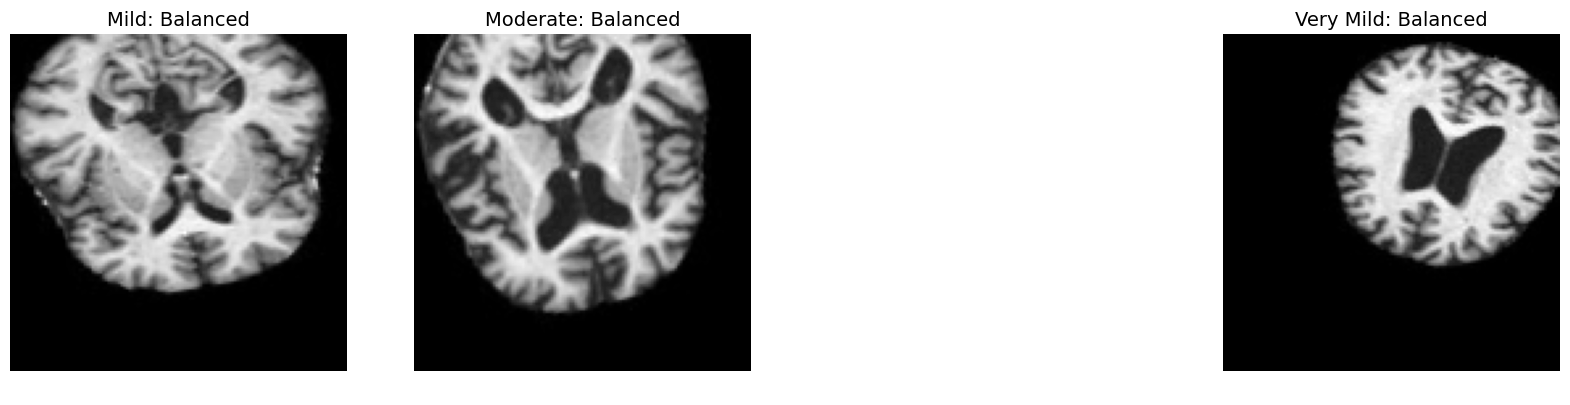

In [0]:
f, ax = plt.subplots(1, 4, figsize=(20, 5))

# Plot balanced images in order of mild, moderate, non, very mild
order = ['Mild', 'Moderate', 'None', 'Very Mild']
label_order = [Lab.index(o) for o in order]

for i, label in enumerate(label_order):
    if Lab[label] != 'None':
        balanced_images = [img for img, lab in zip(train_balanced, train_lab_balanced) if lab == label]
        image_to_plot = balanced_images[0]  # Select the first balanced image of that label
        ax[i].imshow(image_to_plot.reshape(128, 128), cmap='gray')
        ax[i].set_title(f"{Lab[label]}: Balanced", fontsize=14) 
    ax[i].axis('off')

plt.show()

We have to assume that the original images were all registerer to a standard space. While the augmentation created new instances of the minority classes, these images are now not in the same anatomical space. Therefore, this introduces a new bias in that important features, such as specific brain structures, cannot be interpreted in the context of classification. This is in contrast to SMOTE - where synethic data was created in the same anatomical space as the original data, the quality was poor and would also lead to feature bias. Therefore, while less than ideal, using the original unbalanced dataset may be the best option in this case. We can still determine if the class inbalance meaningfully impacts the overall or class-specific classification.

Save the preprocessed dataset for model testing

In [0]:
# Organize preprocessed data
data_preproc = {
    'train_data': np.array([img for img in train['img_arr']]),
    'train_labels': train['label'].values,
    'test_data': np.array([img for img in test['img_arr']]),
    'test_labels': test['label'].values
}

bucket_name="databricks-workspace-stack-brad-personal-bucket"
s3_file_name='AD_MRI_classification/preprocessed/data_preprocessed.pkl'
save_pickle_s3(data_preproc, bucket_name, s3_file_name, dbutils)

Data uploaded to S3 bucket: databricks-workspace-stack-brad-personal-bucket/AD_MRI_classification/preprocessed/data_preprocessed.pkl


In order to address class imbalance, we also implement a stratified cross-validation scheme where the ratio of the different classes is stable across all folds. Since we were already provided with a single training/test set, we combine these together and create multiple training/test sets for multiple cross-validating folds. Since data is generally arbitrarily split, stratification ensures that in a each fold holds the same number of each class. This avoids one fold being completely biased for or against one class.

In [0]:
# Combine training and test sets together
data = np.concatenate((data_preproc['train_data'], data_preproc['test_data']), axis=0)
labels = np.array(np.concatenate((data_preproc['train_labels'], data_preproc['test_labels']), axis=0))

# Split data into 5 train/test sets
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_idx_fold = []
test_idx_fold = []
for train_idx, test_idx in skf.split(labels, labels):
    y_train, y_test = labels[train_idx], labels[test_idx]
    train_idx_fold.append(train_idx)
    test_idx_fold.append(test_idx)
    
    # Check class balance across train/test sets
    print(f"Training class distribution: {Counter(y_train)}")
    print(f"Testing class distribution: {Counter(y_test)}")
    print()

# Organize preprocessed data
data_preproc_xfold = {
    'data': data,
    'labels': labels,
    'train_idx_fold': train_idx_fold,
    'test_idx_fold': test_idx_fold
}

bucket_name="databricks-workspace-stack-brad-personal-bucket"
s3_file_name='AD_MRI_classification/preprocessed/data_preprocessed_xfold.pkl'
save_pickle_s3(data_preproc_xfold, bucket_name, s3_file_name, dbutils)

Training class distribution: Counter({2: 2560, 3: 1792, 0: 716, 1: 52})
Testing class distribution: Counter({2: 640, 3: 448, 0: 180, 1: 12})

Training class distribution: Counter({2: 2560, 3: 1792, 0: 717, 1: 51})
Testing class distribution: Counter({2: 640, 3: 448, 0: 179, 1: 13})

Training class distribution: Counter({2: 2560, 3: 1792, 0: 717, 1: 51})
Testing class distribution: Counter({2: 640, 3: 448, 0: 179, 1: 13})

Training class distribution: Counter({2: 2560, 3: 1792, 0: 717, 1: 51})
Testing class distribution: Counter({2: 640, 3: 448, 0: 179, 1: 13})

Training class distribution: Counter({2: 2560, 3: 1792, 0: 717, 1: 51})
Testing class distribution: Counter({2: 640, 3: 448, 0: 179, 1: 13})

Data uploaded to S3 bucket: databricks-workspace-stack-brad-personal-bucket/AD_MRI_classification/preprocessed/data_preprocessed_xfold.pkl
